# The Ultimate Sphere Observation Table ...

The tables used here have been made by analyzing the headers of the roughly 200,000 files taken with Sphere since it started. We look for the coordinates and match them to the closest SIMBAD star-like object (under the assumption that all host-stars that have been observed were... stars. For the GTO table this is pretty much certain, for non-GTO observations the list has to be taken with a grain of salt. It is probably save to assume that "almost all" observations that were obtained in pupil-stabilized mode were of stars. You can easily filter for those, more on that later). We take into account the proper motion difference between J2000 and the time of observation of the stellar field. The median difference between header position and adjusted best matching Simbad position is ~1.6" (with a spread of ~3"), overall we are pretty close to the pointing accuracy of the VLTs, which is 1" at best, often worse if the guide star is far away.

In the table you can find entries to the nearest star-like object to the matched position, including name, separation, object type, stellar type, and brightness. This allows to evaluate how reliable the association is (e.g., if there is no other star in the 2 arcminute field of query, you can savely assume that there is no confusion...). The nearest star-like object is STRICLY stellar (to make sure we don't pick up radio sources etc, which are not interesting with regards to direct imaging). I also enforced a brightness limit of J<13 mag for the stellar matching as most high-contrast observations will require a bright star for AO. 
There is another column showing if there are any entries on simbad ending on a small letter " b", " c" etc, indicating a low-mass companion.

Most subsequent columns relate to the details of the observations sequence, such as whether it has been taken in continuous waffle mode, the filter, time of observation, total integration time, observing conditions etc. 

Let's import some useful packages and the Sphere_database class.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.table import Table, Column, vstack
from astropy.time import Time

from astropy.coordinates import SkyCoord
from astropy import units as u

from spherical.sphere_database.sphere_database import Sphere_database

import pandas as pd

from tqdm import tqdm

Next we read the two tables containing the all observations (up to April 2024) and the table of SPHERE files (that can be used to find files associated with an observation) to make a Sphere_database object.

In [3]:
table_of_observations = Table.read(
    '/home/samland/sphere/database/table_of_IFS_observations_all_24_04_28.fits'
)
table_of_observations['DISTANCE'] = 1. / (1e-3 * table_of_observations['PLX'].data) * u.pc
table_of_files = Table.read(
    '/home/samland/sphere/database/table_of_files_all_24_04_28.csv'
)
database = Sphere_database(
    table_of_observations=table_of_observations,
    table_of_files=table_of_files,
    instrument='IFS',
)

Now let's have a look at the table of observations. You can visualize the table in your browser or in the notebook directly. Here is the example of opening it in the browser, with java script to make it searchable and sortable.
As you can will see it's a big list.

In [4]:
database.show_in_browser(summary=None, usable_only=True)
# np.unique(database.table_of_files["DPR_TYPE"])

Text(0.5, 0, 'Mean DIMM Seeing (arcsec)')

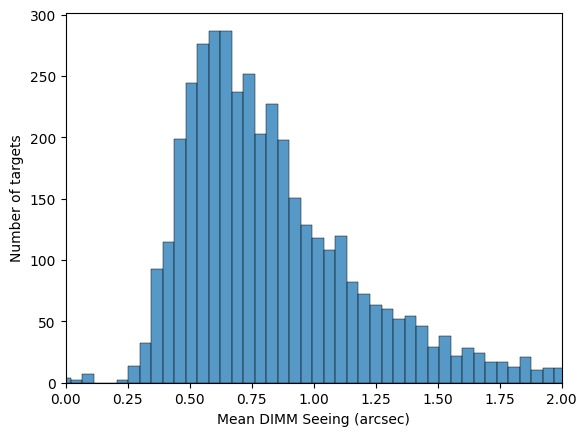

In [12]:
im = sns.histplot(table_of_observations.to_pandas()['MEAN_FWHM'], bins=100)
im.axes.set_xlim(0, 2.)
plt.ylabel('Number of targets')
plt.xlabel('Mean DIMM Seeing (arcsec)')

Let's have a quick look at the difference in position from the header of the SPHERE files used to construct the target list and the catalogue position. Generally the offset is small.

In [15]:
# im = sns.histplot(table_of_observations.to_pandas()['POS_DIFF'], bins=100)
# im.axes.set_xlim(0, 10)
# plt.ylabel('Normalized KDE')
# plt.xlabel('Position difference (arcsec)')

## Example of filter for observations

In [5]:
print(f"Number of total observations: {len(table_of_observations)}")
print(f"Number of unique targets: {len(np.unique(table_of_observations['MAIN_ID']))}")

Number of total observations: 4116
Number of unique targets: 2104


As you can see SPHERE has been very prolific and many stars have been observed for multiple epochs of observation. However, this list is unwieldy, so let's apply some more filters. We will select only observations that follow some minimum requirement on quality for high-contrast imaging. They should be observed in pupil-stabilized mode for ADI, have a minimum exposure time, should not have any flags that would indicate that they are missing important data (like flux calibration or centering frames) or were aborted (this is summarized in the FAILED_SEQ column). For good measure we also filter for good seeing based on the DIMM values in the header (not the most reliable, but better than nothing), bright stars for good AO performance and a nearby distance below 100 pc.

Of course any other combination or additional filters can be applied, as there is also information such as spectral type of the star, although some additional code might have to be used to filter these properly.

In [5]:
mask = np.logical_and.reduce([
    table_of_observations['DEROTATOR_MODE'] == 'PUPIL',
    table_of_observations['TOTAL_EXPTIME'] > 15.,
    table_of_observations['FAILED_SEQ'] == False,
    table_of_observations['MEAN_FWHM'] < 1.2,
    table_of_observations['FLUX_J'] < 8,
    table_of_observations['DISTANCE'] < 300]
)
print("Number of total observations: {}".format(len(table_of_observations)))
print("Number of good observations fulfilling criteria: {}".format(np.sum(mask)))

Number of total observations: 4119
Number of good observations fulfilling criteria: 1281


In [13]:
table_of_observations[mask].show_in_browser(jsviewer=True)

Text(0.5, 0, 'Distance (pc)')

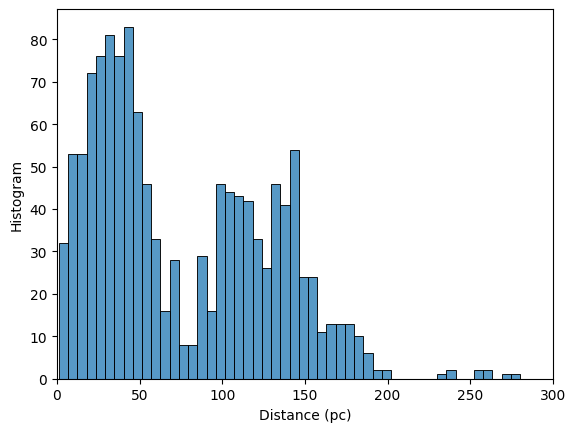

In [31]:
im = sns.histplot(table_of_observations[mask].to_pandas()['DISTANCE'], bins=50)
im.axes.set_xlim(0, 300)
plt.ylabel('Histogram')
plt.xlabel('Distance (pc)')

I defined some additional useful methods in this class, but it mostly makes use of what astropy tables can already do, like displaying the table in your browser with javascript so that you can order the table according to column values and use search functionality. There are two parameters for this function. 

"summary" can either be: None -> display all columns, 'NORMAL' -> gets rid of some columns that may not be immediately interesting, and 'SHORT' to get a very condensed view with only the most important information.
'OBSLOG' -> A digest of important headers

"usable_only" can be True or False. If True, the table is pre-filtered to exclude all observation sequences that have been flagged as "bad" (e.g., missing crucial centering or flux frames, or important calibration data), where not obtained in ADI (pupil stabilized) mode, and have an total exposure time less than 20 minutes. 


In [18]:
database.show_in_browser(summary=None, usable_only=False)

The minimum exposure time can be changed using the following method

In [6]:
database._mask_not_usable_observations(minimum_total_exposure_time=15)

array([ True,  True, False, ...,  True,  True,  True])

In [7]:
database.show_in_browser(summary='SHORT', usable_only=True)

Next, let's take a look at another method of the Sphere_database class: observation_from_name

This method can take the same arguments "summary" and "usable_only", but takes a target name as the first argument. It then resolves the coordinates from the name using Simbad and returns an astropy table with all observations in the observation database that match. Let's try this on beta pictoris...

In [7]:
from copy import copy
database_target = copy(database)

In [8]:
database_target.table_of_observations = database.get_observation_SIMBAD('HR 8799')
database_target.show_in_browser(summary='OBSLOG')

In [23]:
database_wolfgang = copy(database)
mask_wolfgang = np.logical_and.reduce([
    table_of_observations['DEROTATOR_MODE'] == 'PUPIL',
    table_of_observations['TOTAL_EXPTIME'] > 15.,
    table_of_observations['FAILED_SEQ'] == False,
    table_of_observations['DISTANCE'] < 10]
)
database_wolfgang.table_of_observations = table_of_observations[mask_wolfgang]
database_wolfgang.show_in_browser(summary='SHORT')

In [79]:
from astropy.time import Time
cutoff = Time('2022-09-06').mjd

In [80]:
cutoff

59828.0

In [24]:
mask = np.logical_and.reduce([
    table_of_observations['DEROTATOR_MODE'] == 'PUPIL',
    table_of_observations['TOTAL_EXPTIME'] > 30.,
    table_of_observations['FAILED_SEQ'] == False,
    table_of_observations['MEAN_FWHM'] < 1.4,
    # table_of_observations['FLUX_J'] < 8,
    table_of_observations['DISTANCE'] < 10,
])
    # table_of_observations['MJD_MEAN'] < cutoff])
obs = table_of_observations[mask]
#     table_of_observations['MEAN_FWHM'] < 0.8,
#     table_of_observations['FLUX_J'] < 8,
df = obs.to_pandas()

In [10]:
df = table_of_observations.copy().to_pandas()

gs_bool = df.groupby(['MAIN_ID'])['MAIN_ID'].transform('size') > 5
print(gs_bool)

multi_epoch = df[gs_bool]
# group_obs = masked_obs.group_by([])
print(np.sum(gs_bool))

0       False
1       False
2       False
3       False
4       False
        ...  
4114     True
4115     True
4116    False
4117    False
4118    False
Name: MAIN_ID, Length: 4119, dtype: bool
735


In [12]:
Table.from_pandas(multi_epoch).show_in_browser(jsviewer=True)
# test = Table.from_pandas(multi_epoch)
# test.show_in_browser(jsviewer=True)

In [ ]:
# https://archive.eso.org/wdb/wdb/eso/sched_rep_arc/query?progid=098.C-0526(A)

In [48]:
print(obs.group_by(['MAIN_ID', 'NIGHT_START']).groups.keys)

  MAIN_ID    NIGHT_START
------------ -----------
    * 12 Psc  2023-07-13
    * 12 Tri  2016-08-27
    * 18 Boo  2016-06-11
    * 29 Vul  2018-10-18
   * 3 Cen A  2019-02-21
    * 30 Mon  2016-01-18
    * 30 Mon  2016-12-15
    * 30 Mon  2018-12-14
    * 30 Ser  2015-06-04
         ...         ...
WRAY 15-1400  2017-08-28
WRAY 15-1400  2023-04-07
WRAY 15-1443  2015-05-11
WRAY 15-1443  2015-05-14
WRAY 15-1443  2019-05-18
WRAY 15-1880  2016-05-18
WRAY 15-1880  2018-07-03
     WT 2353  2019-11-20
    Wolf 851  2016-07-10
Length = 1665 rows


In [22]:
# obs = database.observations_from_name_SIMBAD(['HD114174'], summary='OBSLOG', usable_only=False)
# obs = database.observations_from_name_SIMBAD(['HD95086'], summary=None, usable_only=True)
# obs = database.observations_from_name_SIMBAD(['51 eri'], summary='OBSLOG', usable_only=True)
# obs = database.observations_from_name_SIMBAD(['mu2 sco'], summary='OBSLOG', usable_only=False)
# obs = database.observations_from_name_SIMBAD(['HIP 15201'], summary='OBSLOG', usable_only=False)
# obs = database.observations_from_name_SIMBAD(['GQ Lup'], summary='OBSLOG', usable_only=False)
# obs = database.observations_from_name_SIMBAD(['HIP 21152'], summary='OBSLOG', usable_only=False)
# obs = database.observations_from_name_SIMBAD(['HR 2562'], summary='OBSLOG', usable_only=False)
# obs = database.observations_from_name_SIMBAD(['beta pic'], summary='OBSLOG', usable_only=True)
obs = database.observations_from_name_SIMBAD(['HR8799'], summary='OBSLOG', usable_only=True)
# obs = database.observations_from_name_SIMBAD(['HD2133'], summary='OBSLOG', usable_only=True)
# obs.show_in_browser()
# target_table_mask = np.logical_and.reduce([
#     obs['TOTAL_EXPTIME'] > 15,
#     obs['MEAN_FWHM'] >  1.2,
#     obs['DATE_SHORT'] != '2016-04-15',
#     obs['DATE_SHORT'] != '2016-04-16',
#     obs['DATE_SHORT'] != '2019-12-22'])
# obs[target_table_mask]
obs


MAIN_ID,IFS_MODE,NIGHT_START,WAFFLE_MODE,FAILED_SEQ,DEROTATOR_MODE,DIT,NDIT,NCUBES,TOTAL_EXPTIME,MEAN_FWHM,MEAN_TAU,OBS_PROG_ID
bytes34,bytes6,bytes10,bool,bool,bytes10,float64,int64,int64,float64,float64,float64,bytes16
HD 218396,OBS_YJ,2014-07-12,False,False,PUPIL,8.0,20,14,37.333333333333336,-1.0,0.0058,60.A-9249(B)
HD 218396,OBS_H,2014-08-11,False,False,PUPIL,100.0,2,32,101.33333333333333,0.7132812500000001,0.0027875,60.A-9249(C)
HD 218396,OBS_H,2015-07-03,False,False,PUPIL,64.0,4,15,64.0,-0.24333333333333335,0.0020066666666666666,095.C-0298(C)
HD 218396,OBS_H,2015-09-27,False,False,PUPIL,16.0,16,16,68.26666666666667,0.8274999999999999,0.01663125,095.C-0298(D)
HD 218396,OBS_YJ,2016-11-17,True,False,PUPIL,64.0,16,4,68.26666666666667,0.85625,0.0028499999999999992,198.C-0209(B)
HD 218396,OBS_YJ,2017-06-14,True,False,PUPIL,32.0,36,3,57.6,0.9183333333333334,0.0028333333333333335,198.C-0209(J)
HD 218396,OBS_YJ,2017-10-07,True,False,PUPIL,64.0,7,35,261.3333333333333,0.6427142857142857,0.005448571428571428,099.C-0588(A)
HD 218396,OBS_YJ,2017-10-11,True,False,PUPIL,64.0,7,35,261.3333333333333,0.6077142857142858,0.005205714285714286,099.C-0588(A)
HD 218396,OBS_YJ,2017-10-12,True,False,PUPIL,64.0,7,33,246.4,0.664090909090909,0.005087878787878789,099.C-0588(A)


In [8]:
obs.show_in_notebook()

idx,MAIN_ID,IFS_MODE,DATE_SHORT,WAFFLE_MODE,FAILED_SEQ,DEROTATOR_MODE,DIT,NDIT,NCUBES,TOTAL_EXPTIME,MEAN_FWHM,MEAN_TAU,OBS_PROG_ID
0,** KOU 2C,OBS_H,2015-02-03,True,False,PUPIL,64.0,1,31,32.53333333333333,0.6764516129032259,0.022545161290322583,095.C-0298(H)
1,** KOU 2C,OBS_YJ,2015-05-04,False,False,PUPIL,64.0,4,8,34.13333333333333,0.849375,0.001975,095.C-0298(A)
2,** KOU 2C,OBS_H,2015-05-05,False,False,PUPIL,64.0,4,12,51.2,0.7804166666666665,0.0021166666666666664,095.C-0298(A)
3,** KOU 2C,OBS_YJ,2015-05-05,False,False,PUPIL,64.0,4,8,34.13333333333333,0.6400000000000001,0.0026375,095.C-0298(A)
4,** KOU 2C,OBS_YJ,2015-05-11,False,False,PUPIL,64.0,4,12,51.2,1.0920833333333333,0.0027583333333333336,095.C-0298(A)
5,** KOU 2C,OBS_YJ,2015-05-12,False,False,PUPIL,64.0,4,4,17.066666666666666,1.0262499999999999,0.0036,095.C-0298(A)
6,** KOU 2C,OBS_H,2016-01-18,False,False,PUPIL,64.0,5,16,85.33333333333333,1.6065625000000001,0.001775,096.C-0241(G)
7,** KOU 2C,OBS_YJ,2016-04-16,False,False,PUPIL,64.0,19,4,81.06666666666666,0.6387499999999999,0.0052499999999999995,097.C-0865(A)
8,** KOU 2C,OBS_H,2016-05-30,True,False,PUPIL,64.0,10,5,53.333333333333336,0.66,0.0035000000000000005,097.C-0865(B)
9,** KOU 2C,OBS_H,2016-05-31,True,False,PUPIL,64.0,10,2,21.333333333333332,0.58,0.0030499999999999998,097.C-0865(B)


In [26]:
obs = database.observations_from_name_SIMBAD(['HD2133'], summary='OBSLOG', usable_only=True)
target_table_mask = np.logical_and.reduce([
    obs['TOTAL_EXPTIME'] > 15,
#     obs['MEAN_FWHM'] <  1.2,
#      obs['MAIN_ID'] == 'HD 95086'
])
obs.show_in_notebook()

idx,MAIN_ID,IFS_MODE,DATE_SHORT,WAFFLE_MODE,FAILED_SEQ,DEROTATOR_MODE,DIT,NDIT,NCUBES,TOTAL_EXPTIME,MEAN_FWHM,MEAN_TAU,OBS_PROG_ID
0,HD 2133,OBS_YJ,2015-10-25,False,False,PUPIL,64.0,4,16,68.26666666666667,1.4812500000000002,0.001075,096.C-0241(A)
1,HD 2133,OBS_H,2015-10-27,False,False,PUPIL,64.0,4,4,17.066666666666666,1.39875,0.00125,096.C-0241(A)
2,HD 2133,OBS_YJ,2015-11-28,False,False,PUPIL,32.0,1,16,8.533333333333333,1.1746874999999999,0.007325,096.C-0241(B)
3,HD 2133,OBS_H,2016-06-13,False,False,PUPIL,64.0,1,16,17.066666666666666,0.6996875,0.00393125,097.C-0865(F)
4,HD 2133,OBS_YJ,2016-09-16,False,False,PUPIL,64.0,1,20,21.333333333333332,0.6415,0.00555,097.C-0865(D)
5,HD 2133,OBS_YJ,2016-11-18,False,False,PUPIL,64.0,1,16,17.066666666666666,0.598125,0.0054625,198.C-0209(B)
6,HD 2133,OBS_YJ,2016-12-12,False,False,PUPIL,64.0,1,14,14.933333333333334,1.7914285714285716,0.0013857142857142857,198.C-0209(C)
7,HD 2133,OBS_H,2017-11-04,False,False,PUPIL,64.0,1,16,17.066666666666666,0.7078125000000001,0.00268125,1100.C-0481(B)
8,HD 2133,OBS_H,2017-11-30,False,False,PUPIL,64.0,1,16,17.066666666666666,0.57875,0.005775,1100.C-0481(A)
9,HD 2133,OBS_H,2018-01-05,False,False,PUPIL,64.0,1,16,17.066666666666666,1.010625,0.00780625,1100.C-0481(E)


In [5]:
gto_phot = database_gto.observations_from_name_SIMBAD(['HD 100546'], summary='SHORT', usable_only=True)
gto_phot

NameError: name 'database_gto' is not defined

In [17]:
table_of_observations[table_of_observations['DATE_SHORT'] == '2015-07-04']

MAIN_ID,HD_ID,HIP_ID,RA,DEC,OTYPE,SP_TYPE,FLUX_V,FLUX_R,FLUX_I,FLUX_J,FLUX_H,FLUX_K,ABS_PM,PM_RA,PM_DEC,PM_RA_ERR,PM_DEC_ERR,PLX,PLX_ERR,PLX_BIBCODE,OBJ_HEADER,RA_DEG,DEC_DEG,RA_HEADER,DEC_HEADER,POS_DIFF,STARS_IN_CONE,NEAREST_STAR,SEPARATION_NEAREST,NEAREST_OTYPE,NEAREST_STYPE,NEAREST_FLUX_H,COMPANION_NAME,NUMBER_COMPANIONS,DATE_SHORT,OBS_START,OBS_END,MJD_MEAN,INSTRUMENT,DB_FILTER,ND_FILTER,ND_FILTER_FLUX,WAFFLE_MODE,NON_CORO_MODE,FAILED_SEQ,TOTAL_EXPTIME,DIT,NDIT,NCUBES,NCENTER,SCI_DIT_FLAG,DIT_FLUX,NDIT_FLUX,NFLUX,FLUX_FLAG,NSKY,MEAN_TAU,STDDEV_TAU,MEAN_FWHM,STDDEV_FWHM,MEAN_AIRMASS,DEROTATOR_MODE,WAFFLE_AMP,OBS_ID,OBS_PROG_ID,TOTAL_FILE_SIZE
,,,,,,,mag,mag,mag,mag,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,,,deg,deg,deg,deg,arcsec,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes29,bytes10,bytes10,bytes13,bytes13,bytes19,bytes16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float64,float32,bytes19,bytes31,float64,float64,float64,float64,float64,int64,bytes32,float64,bytes17,bytes15,bytes32,bytes28,int64,bytes10,float64,float64,float64,bytes5,bytes13,bytes6,bytes6,bool,bool,bool,float64,float64,int64,int64,int64,bool,float64,int64,int64,bool,int64,float64,float64,float64,float64,float64,bytes10,float64,int64,bytes16,float64
HD 106906,HD 106906,HIP 59960,12 17 53.1914,-55 58 31.890,Star,F5V,8.89,8.46,1e+20,6.946,6.759,6.683,41.08260678194606,-39.014,-12.872,0.057,0.046,9.677,0.0429,2018yCat.1345....0G,HIP 59960,184.4716308333333,-55.975525000000005,184.471066,-55.97514,1.6727752923588137,2,HD 106906B,7.197051030617626,brownD*,L2.5,-10000,none,0,2015-07-04,57207.02657997,57207.03298149,57207.02838658223,IRDIS,BB_Ks,OPEN,N/A,False,False,True,4.0,16.0,1,9,2,True,0.0,0,0,True,3,0.0010888888888888888,9.938079899999061e-05,1.0983333333333334,0.9407827710062628,1.329,FIELD,0.05,200358986,095.C-0298(C),0.6739200000000001
HD 106906,HD 106906,HIP 59960,12 17 53.1914,-55 58 31.890,Star,F5V,8.89,8.46,1e+20,6.946,6.759,6.683,41.08260678194606,-39.014,-12.872,0.057,0.046,9.677,0.0429,2018yCat.1345....0G,HIP 59960,184.4716308333333,-55.975525000000005,184.471066,-55.97514,1.6727752923588137,2,HD 106906B,7.197051030617626,brownD*,L2.5,-10000,none,0,2015-07-04,57207.00290623,57207.01728053,57207.00670980001,IRDIS,DB_K12,OPEN,ND_1.0,False,False,False,16.0,64.0,5,3,1,False,0.0,0,1,True,3,0.0014333333333333333,4.714045207910318e-05,1.2516666666666667,0.0913175168786849,1.2659999999999998,PUPIL,0.05,200358971,095.C-0298(C),0.24192000000000002
HD 114174,HD 114174,HIP 64150,13 08 51.0231,+05 12 26.064,**,G3IV+D,1e+20,6.3,1e+20,5.613,5.312,5.202,685.5932684828521,85.365,-680.258,0.082,0.071,37.914,0.0517,2018yCat.1345....0G,hd114174,197.21259624999996,5.2072400000000005,197.212788,5.20396,nan,0,none,0.0,none,none,none,none,0,2015-07-04,57207.94908515,57207.97937416,57207.96546368799,IRDIS,DB_H23,OPEN,ND_2.0,False,False,False,42.666666666666664,32.0,8,10,1,False,0.0,0,1,True,0,0.0026500000000000004,0.00018574175621006718,-0.3125,0.8897422379543415,1.1542,PUPIL,0.03,200359019,095.C-0298(C),0.7776000000000001
HD 169142,HD 169142,,18 24 29.7799,-29 46 49.328,Ae*,F1VekA3mA3_lB?,8.16,1e+20,1e+20,7.31,6.911,6.41,37.867136358589356,-2.320,-37.796,0.112,0.093,8.775,0.0636,2018yCat.1345....0G,HD169142,276.1240829166666,-29.780368888888887,276.12378,-29.78003,2.0224285825234953,4,2MASS J18242929-2946559,9.711634910904744,TTau*,,9.27,HD 169142b,1,2015-07-04,57207.09266336,57207.10476976,57207.103233425005,IRDIS,DB_K12,OPEN,ND_1.0,False,False,False,8.533333333333333,64.0,4,2,2,False,0.837464,27,2,False,0,0.0018,0.0,1.105,0.015000000000000013,1.105,PUPIL,0.04,200358992,095.C-0298(C),0.16128
TYC 1718-851-1,,,23 07 24.5842,+21 08 01.065,Star,G0,9.75,1e+20,1e+20,7.574,6.975,6.843,25.980693793661473,-19.915,-16.685,0.066,0.047,2.085,0.0352,2018yCat.1345....0G,HIP_114189,346.8524341666666,21.133629166666665,346.869375,21.13388,57.20566752775243,0,none,0.0,none,none,none,HD 218396b,1,2015-07-04,57207.37649

In [72]:
gto_phot = database.observations_from_name_SIMBAD(['51 eri'], summary='SUMMARY', usable_only=False)
gto_phot.show_in_browser(jsviewer=True)

In [9]:
gto_phot = database_gto.observations_from_name_SIMBAD(['HD2133'], summary=None, usable_only=False)
gto_phot.show_in_browser(jsviewer=True)

Best conditions (Mean FWHM)

White Dwarfs
Hot
CD-56 7708 DB_H23 2017-04-29
CD-56 7708 DB_K12 2016-10-14
HD 2133 DB_H23 2016-11-18 (bad leakage! example for when center doesn't work)
HD 2133 DB_K12 2016-06-13

Cold
HD 114174 DB_H23 2015-05-04
HD 114174 DB_K12 2017-02-08

Sirius-like single star
HD 84503 DB_H23 2016-04-16
HD 84503 DB_K12 2016-01-02


In [3]:
# many_observations = database_gto.observations_from_name(['beta pictoris', '51 Eri', 'GQ Lup'], 'SHORT', usable_only=True)
# many_observations = database_gto.observations_from_name_SIMBAD(['HIP65426', '51 Eri'], 'SUMMARY', usable_only=True)
# many_observations = database_gto.observations_from_name(['EM* AS 220'], 'SHORT', usable_only=False)
# many_observations = database_gto.observations_from_name(['HIP65426'], 'SHORT', usable_only=True)
# many_observations = database_non_gto.observations_from_name(['HD 104231'], 'SUMMARY', usable_only=False)
# many_observations = database_non_gto.observations_from_name(['HR8799'], 'SUMMARY', usable_only=False)
# many_observations = database_gto.observations_from_name(['CD-65149'], 'SUMMARY', usable_only=False)
# many_observations = database_gto.observations_from_name(['beta pictoris'], 'SHORT', usable_only=True)



In [67]:
many_observations = database_gto.observations_from_name_SIMBAD(['CI Tau'], 'SUMMARY', usable_only=True)
# many_observations = database_IFS_gto.observations_from_name_SIMBAD(['51 Eri'], 'SUMMARY', usable_only=True)
many_observations.show_in_browser(jsviewer=True)

NameError: name 'database_gto' is not defined

In [8]:
# beta_pic_non_gto = database_non_gto.observations_from_name(['HD 114174', 'HD223816'], 'NORMAL')
# beta_pic_non_gto = database_non_gto.observations_from_name(['HD 114174', 'HD223816'], 'NORMAL')
beta_pic_non_gto

MAIN_ID,HD_ID,HIP_ID,RA,DEC,OTYPE,SP_TYPE,FLUX_H,STARS_IN_CONE,NEAREST_STAR,SEPARATION_NEAREST,NEAREST_OTYPE,NEAREST_STYPE,NEAREST_FLUX_H,COMPANION_NAME,NUMBER_COMPANIONS,DATE_SHORT,DB_FILTER,WAFFLE_MODE,FAILED_SEQ,TOTAL_EXPTIME,MEAN_FWHM,TOTAL_FILE_SIZE
,,,"""h:m:s""","""d:m:s""",,,mag,,,arcsec,,,,,,,,,,,,
bytes25,bytes10,bytes10,bytes13,bytes13,bytes14,bytes21,float32,int64,bytes32,float64,bytes13,bytes10,bytes6,bytes24,int64,bytes10,bytes13,int64,int64,float64,float64,float64


The retrieved astropy tables can be used as any normal astropy table. So "show_in_browser(jsviewer=True)" displays them in your browser with javascript. "beta_pic_short.write('Beta_pic_table.fits')" would save it to your folder etc.

In [10]:
beta_pic_table.show_in_browser(jsviewer=True)

In [15]:
database_gto.table_of_observations.colnames

['MAIN_ID',
 'HD_ID',
 'HIP_ID',
 'RA',
 'DEC',
 'OTYPE',
 'SP_TYPE',
 'FLUX_V',
 'FLUX_R',
 'FLUX_I',
 'FLUX_J',
 'FLUX_H',
 'FLUX_K',
 'ABS_PM',
 'PM_RA',
 'PM_DEC',
 'PM_RA_ERR',
 'PM_DEC_ERR',
 'PLX',
 'PLX_ERR',
 'PLX_BIBCODE',
 'OBJ_HEADER',
 'RA_DEG',
 'DEC_DEG',
 'RA_HEADER',
 'DEC_HEADER',
 'POS_DIFF',
 'STARS_IN_CONE',
 'NEAREST_STAR',
 'SEPARATION_NEAREST',
 'NEAREST_OTYPE',
 'NEAREST_STYPE',
 'NEAREST_FLUX_H',
 'COMPANION_NAME',
 'NUMBER_COMPANIONS',
 'DATE_SHORT',
 'OBS_START',
 'OBS_END',
 'MJD_MEAN',
 'INSTRUMENT',
 'DB_FILTER',
 'ND_FILTER',
 'ND_FILTER_FLUX',
 'WAFFLE_MODE',
 'NON_CORO_MODE',
 'FAILED_SEQ',
 'TOTAL_EXPTIME',
 'DIT',
 'NDIT',
 'NCUBES',
 'NCENTER',
 'SCI_DIT_FLAG',
 'DIT_FLUX',
 'NDIT_FLUX',
 'NFLUX',
 'FLUX_FLAG',
 'NSKY',
 'MEAN_TAU',
 'STDDEV_TAU',
 'MEAN_FWHM',
 'STDDEV_FWHM',
 'MEAN_AIRMASS',
 'DEROTATOR_MODE',
 'WAFFLE_AMP',
 'OBS_ID',
 'OBS_PROG_ID',
 'TOTAL_FILE_SIZE']

In [7]:
a = database_gto.table_of_observations
mask = np.logical_and.reduce([a['DIT'] < 64, a['TOTAL_EXPTIME'] > 35, a['DEROTATOR_MODE'] == 'PUPIL', a['FAILED_SEQ'] == False, a['WAFFLE_MODE'] == True])

In [8]:
b = database_non_gto.table_of_observations
non_gto_mask = np.logical_and.reduce([b['DIT'] < 64, b['TOTAL_EXPTIME'] > 35, b['DEROTATOR_MODE'] == 'PUPIL', b['FAILED_SEQ'] == False, b['WAFFLE_MODE'] == True])

In [30]:
mask

array([False, False, False, ..., False, False, False])

In [10]:
database_gto.table_of_observations = database_gto.table_of_observations[mask]
database_non_gto.table_of_observations = database_non_gto.table_of_observations[non_gto_mask]

In [11]:
database_gto.show_in_browser(summary='MEDIUM')

In [12]:
database_non_gto.show_in_browser(summary='MEDIUM')